Steps to follow 
===
1) Question or problem definition.
--
2) Acquire training and testing data. 
--
3) Wrangle, prepare, cleanse the data.
--
4) Analyze, identify patterns, and explore the data.
--
5) Model, predict and solve the problem.
--
6) Visualize, report, and present the problem solving steps and final solution.
--

I Question & Problem Definition
==
We want to create a trading bot which can make decisions : BUY / SELL / HOLD (Classification problem). <br>
To do this we have previously created a database (.csv file) in which we have put different indicators. <br>
With those indicators we expect to be able to predict this decision. <br>
We need to create a pertinent label to predict. <br>
To know : on GDAX the fee on each transaction is 0.3%. <br>

First naive label
--
-1 on each chandelier on which we have a decrease of at least 0.3% <br>
+1 on each chandelier on which we have a increase of at least 0.3% <br>
0 if between -0.3 and 0.3% <br>


II Acquire training and testing data
===
We have done all those steps in another algorithm which is giving us a csv file ouput. <br>
Note : In our dataset we have already solved the problem of NaN values.

III Wrangle, prepare, cleanse the data
===
Once we have import our csv file, we need to create some features that could be useful to our study. <br>

First step
----
We are transforming our first dataset to have new interesting features

In [1]:
import pandas as pd
import numpy as np
import results
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-poster')

file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600.csv')


# Normalisation
# This allows to have all our data on the same scale. To this end it is relevant to compare different chandelier together

df_primary['bdb_high_n'] = df_primary['bdb_high'] / df_primary['opening_price']
df_primary['bdb_low_n'] = df_primary['bdb_low'] / df_primary['opening_price']
df_primary['high_price_n'] = df_primary['high_price'] / df_primary['opening_price']
df_primary['low_price_n'] = df_primary['low_price'] / df_primary['opening_price']
df_primary['macd_n'] = df_primary['macd'] / df_primary['opening_price']
df_primary['macd-1'] = df_primary['macd_n'].shift(1)
df_primary['macd-2'] = df_primary['macd_n'].shift(2)
df_primary['macd-3'] = df_primary['macd_n'].shift(3)

# Other variables
# Variation vector creation and its historic in each vector to allow a ML algorithm to see the stock price previous evolution

df_primary['variation'] = (df_primary['closing_price'] - df_primary['opening_price']) / df_primary['opening_price']*100
df_primary['var-1'] = df_primary['variation'].shift(1)
df_primary['var-2'] = df_primary['variation'].shift(2)

# MACD is one of the most important indicator in stock prices classic analysis, we are creating its derivate, and its 
# second derivate to see if there is a correlation with the stock prices
df_primary['macd_derivative_n'] = df_primary['macd_n'] - df_primary['macd_n'].shift(1)
df_primary['macd_second_derivative_n'] = df_primary['macd_derivative_n'] - df_primary['macd_derivative_n'].shift(1)
df_primary['product_macd'] = df_primary["macd_n"]*df_primary['macd_derivative_n']

# Volatility
df_primary['volatility'] = df_primary['high_price_n'] - df_primary['low_price_n']
df_primary['derivate_volatility'] = df_primary['volatility'] - df_primary['volatility'].shift(1)
df_primary['derivate_volume'] = df_primary['volume'] - df_primary['volume'].shift(1)

# Stochastique
df_primary['stochastic_derivative'] = df_primary['stochastic'] - df_primary['stochastic'].shift(1)
df_primary['product_stochastic'] = df_primary["stochastic"]*df_primary['stochastic_derivative']

# Redudancy variables dropped
clear = ['bdb_low', 'bdb_high', 'mme12', 'mme26', 'opening_price',
         'low_price', 'high_price', 'length', 'date', 'macd', 'timestamp']

df_primary = df_primary.drop(clear, axis = 1)


df_primary['closing_price'] = df_primary['closing_price'].shift(1)

df_primary.head()

,closing_price,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,...,var-1,var-2,macd_derivative_n,macd_second_derivative_n,product_macd,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic
0,NaN,9.827998,1.000000,0.993921,0.972270,1.002936,0.999940,0.008307,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.002996,NaN,NaN,NaN,NaN
1,4185.00,15.091203,0.201000,0.991816,0.971955,1.000000,0.990442,0.007894,0.008307,NaN,...,0.293571,NaN,-0.000413,NaN,-3.262892e-06,0.009558,0.006562,5.263205,-0.799000,-0.160599
2,4153.04,31.744749,0.000000,0.998576,0.980936,1.002080,0.981055,0.006018,0.007894,0.008307,...,-0.763680,0.293571,-0.001876,-0.001463,-1.129109e-05,0.021024,0.011466,16.653545,-0.201000,-0.000000
3,4076.02,14.755165,0.642795,1.016936,0.999783,1.006496,0.998110,0.004800,0.006018,0.007894,...,-1.894467,-0.763680,-0.001218,0.000658,-5.846202e-06,0.008385,-0.012639,-16.989584,0.642795,0.413185
4,4094.01,185.642850,0.261647,1.016472,0.989490,1.000002,0.940442,0.000169,0.004800,0.006018,...,0.350023,-1.894467,-0.004631,-0.003413,-7.819367e-07,0.059560,0.051175,170.887684,-0.381148,-0.099726


Second step
----
We have to create our label, this is not a simple as it seems.This is the reason why we are creating 4 differents for now.

In [2]:
# Creation of 4 differents label to see which one is the most correlated to our features, and then choose the easiest one
# to do predictions

# The most basic which is 1 or -1 if the variation during one chandelier is superior to 0.3% variation
# 3-classes classification
def label(data_row, seuil = 0.3):        
    variation = data_row['variation']    
    if variation >= seuil:
        return 1
    elif variation <= - seuil:
        return -1
    else:
        return 0 

# Label useful to see which features are correlated to the biggest variation (with no regards to this variation sense) 
# 2-classes classification
def label_forte_variation(data_row, seuil = 1.5):
    variation = data_row['variation']    
    if variation >= seuil:
        return 1
    elif variation <= - seuil:
        return 1
    else:
        return 0 
# Trend Label, which is rolling on a 24h window and put a 1 (buy) or a -1 (sell) when we are on the maximum of those 24 hours    
# 0 if this is not a maximum. 3-classes classification
def local_extrema_label(window_array):
    if window_array[0] == max(window_array):
        return -1
    elif window_array[0] == min(window_array):
        return 1
    else:
        return 0
    
# Our first 3 labels    
df_primary['label_basique'] = df_primary.apply(label, axis=1)
df_primary['label_forte_variation'] = df_primary.apply(label_forte_variation, axis=1)
window_length = 24
df_primary['label_trend_3_classes'] = df_primary['closing_price'].rolling(window=window_length,center=False
                                ).apply(func=local_extrema_label
                                ).shift(-window_length+1)
df_primary = df_primary.drop('closing_price', axis = 1)

# Final label
# Trend label, equivalent to the first one, instead 0 are replaced by 1 and -1 depending on the trend. 
# 2-classes classification
label = df_primary['label_trend_3_classes'].values.tolist()
new_label = []
high_trend = True

for i in range(len(label)):

    if label[i] in (0,1) and high_trend:
        new_label.append(1)
    elif label[i] == -1 and high_trend:
        high_trend = False
        new_label.append(0)

    elif label[i] in (0,-1) and not high_trend:
        new_label.append(0)
    elif label[i] == 1 and not high_trend:
        high_trend = True
        new_label.append(1)

df_label = pd.DataFrame(new_label, columns = ['label_trend_2_classes'])
df_primary = pd.concat([df_primary, df_label], axis = 1)
df_primary.head()

,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,macd-3,...,product_macd,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic,label_basique,label_forte_variation,label_trend_3_classes,label_trend_2_classes
0,9.827998,1.000000,0.993921,0.972270,1.002936,0.999940,0.008307,NaN,NaN,NaN,...,NaN,0.002996,NaN,NaN,NaN,NaN,0,0,NaN,0.0
1,15.091203,0.201000,0.991816,0.971955,1.000000,0.990442,0.007894,0.008307,NaN,NaN,...,-3.262892e-06,0.009558,0.006562,5.263205,-0.799000,-0.160599,-1,0,-1.0,0.0
2,31.744749,0.000000,0.998576,0.980936,1.002080,0.981055,0.006018,0.007894,0.008307,NaN,...,-1.129109e-05,0.021024,0.011466,16.653545,-0.201000,-0.000000,-1,1,-1.0,0.0
3,14.755165,0.642795,1.016936,0.999783,1.006496,0.998110,0.004800,0.006018,0.007894,0.008307,...,-5.846202e-06,0.008385,-0.012639,-16.989584,0.642795,0.413185,1,0,0.0,0.0
4,185.642850,0.261647,1.016472,0.989490,1.000002,0.940442,0.000169,0.004800,0.006018,0.007894,...,-7.819367e-07,0.059560,0.051175,170.887684,-0.381148,-0.099726,-1,1,-1.0,0.0


Third step
----
We have previously created a decision_vector in strategy_improvement.ipynb. We have imported this resulting vector

In [3]:
#### To remove and improve this decision_vector
#flemme d'importer strategy improvement comme c'est un notebook c'est pas pratique    
decisions_list = [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, -1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.0, 0.0]
decision_vector = [5555]
trend_high = False
for i in range(len(decisions_list)):

    if decisions_list[i] in (0,1) and trend_high:
        decision_vector.append(1)
    elif decisions_list[i] == -1 and trend_high:
        trend_high = False
        decision_vector.append(0)

    elif decisions_list[i] in (0,-1) and not trend_high:
        decision_vector.append(0)
    elif decisions_list[i] == 1 and not trend_high:
        trend_high = True
        decision_vector.append(1)

#results of the whole "strategy_improvement" notebook
df_decision = pd.DataFrame(decision_vector, columns = ['decision_vector'])
     
df_primary = pd.concat([df_primary, df_decision], axis = 1)
df_primary['decision_vector'] = df_primary['decision_vector'].shift(1)   

#We drop our NaN which corresponds to the shifted values (3 rows dropped)

df_primary.dropna(inplace=True)
df_primary.head()


,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,macd-3,...,volatility,derivate_volatility,derivate_volume,stochastic_derivative,product_stochastic,label_basique,label_forte_variation,label_trend_3_classes,label_trend_2_classes,decision_vector
3,14.755165,0.642795,1.016936,0.999783,1.006496,0.998110,0.004800,0.006018,0.007894,0.008307,...,0.008385,-0.012639,-16.989584,0.642795,0.413185,1,0,0.0,0.0,0.0
4,185.642850,0.261647,1.016472,0.989490,1.000002,0.940442,0.000169,0.004800,0.006018,0.007894,...,0.059560,0.051175,170.887684,-0.381148,-0.099726,-1,1,-1.0,0.0,0.0
5,141.111493,0.999927,1.063922,1.035350,1.035192,1.000000,-0.000882,0.000169,0.004800,0.006018,...,0.035192,-0.024368,-44.531356,0.738280,0.738227,1,1,0.0,0.0,1.0
6,100.007762,0.160596,1.027695,0.998875,1.013428,0.990375,-0.002384,-0.000882,0.000169,0.004800,...,0.023053,-0.012140,-41.103732,-0.839332,-0.134793,-1,0,-1.0,0.0,1.0
7,129.721791,0.853758,1.033495,1.003121,1.001240,0.982892,-0.003720,-0.002384,-0.000882,0.000169,...,0.018348,-0.004705,29.714029,0.693162,0.591792,0,0,-1.0,0.0,1.0


IV Analyze, Identify patterns, and explore the data
==
We need to find some correlations between our features and our label.


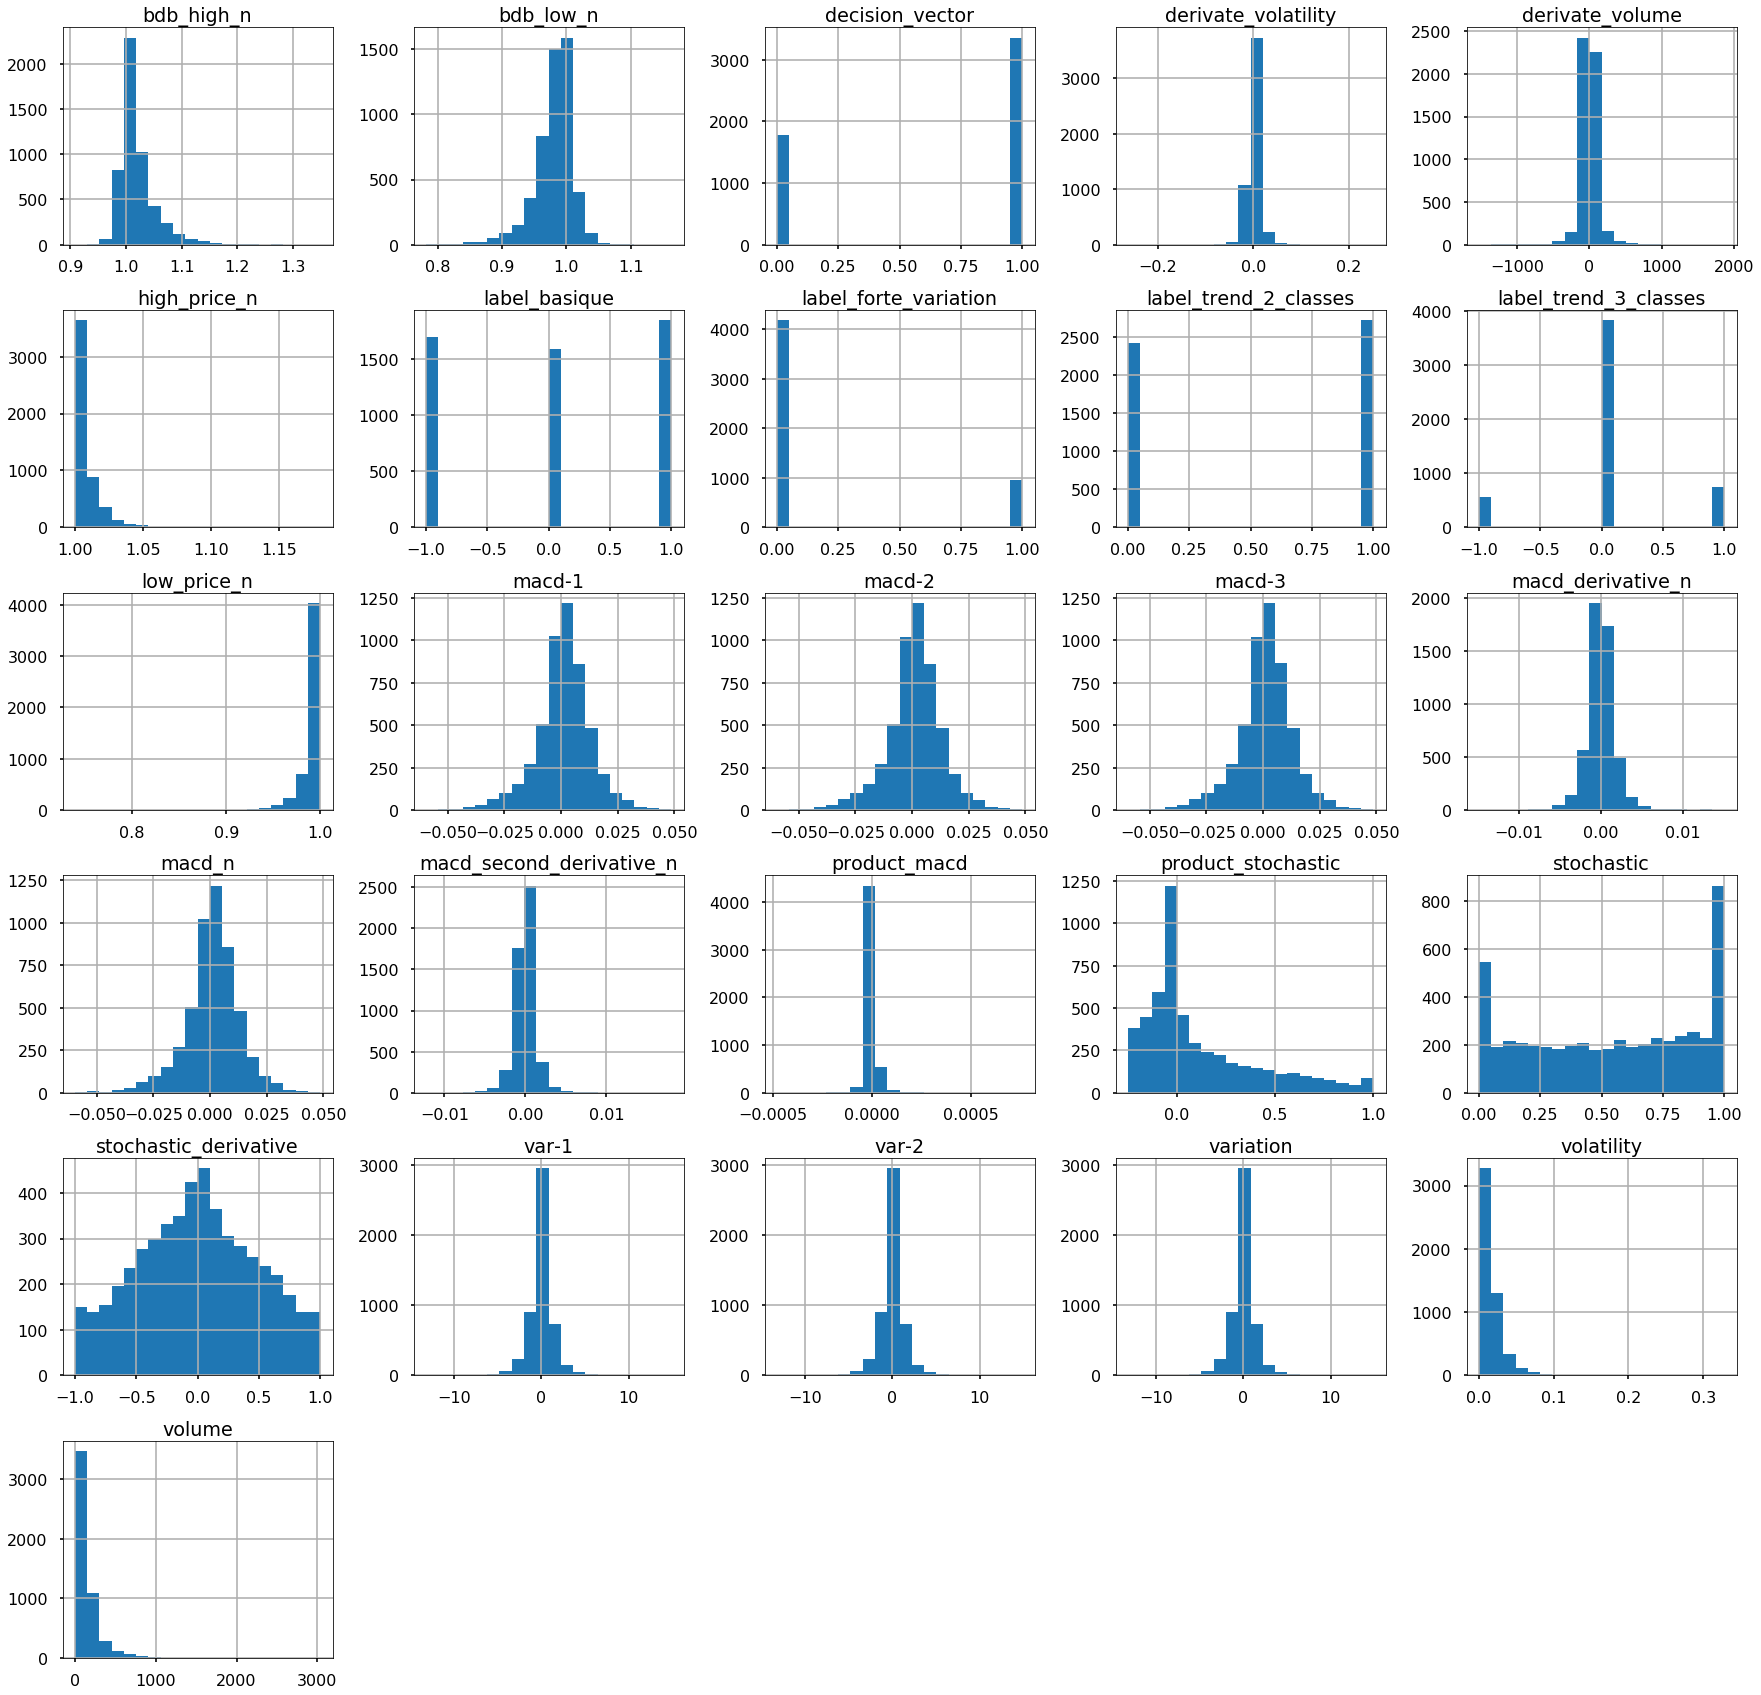

In [4]:
# visualisation of our different parameters
df_primary.hist(bins=20, figsize=(30,30))
plt.show()


Linear correlation with our labels (Pearson correlation)
----

colormap = plt.cm.RdBu
plt.figure(figsize=(24,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_primary.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

The table above is telling us that the label which is the most correlated to all our features is the *label_trend_2_classes*<br>
According to the table and our label, we should take in our model the following features <br>
*decision_vector*<br>
*macd_derivative_n*<br>
*macd_n*<br>
*stochastic*<br>
*bdb_low_n*<br>
*bdb_high_n*<br>
We need to confirm (and complete) this by different analysis 

Categorization of our data
----
We want to discretize our features, this way to compute machine learning algorithms, it will take less time, and the results should be enough to allow us to finish our feature_selection step.

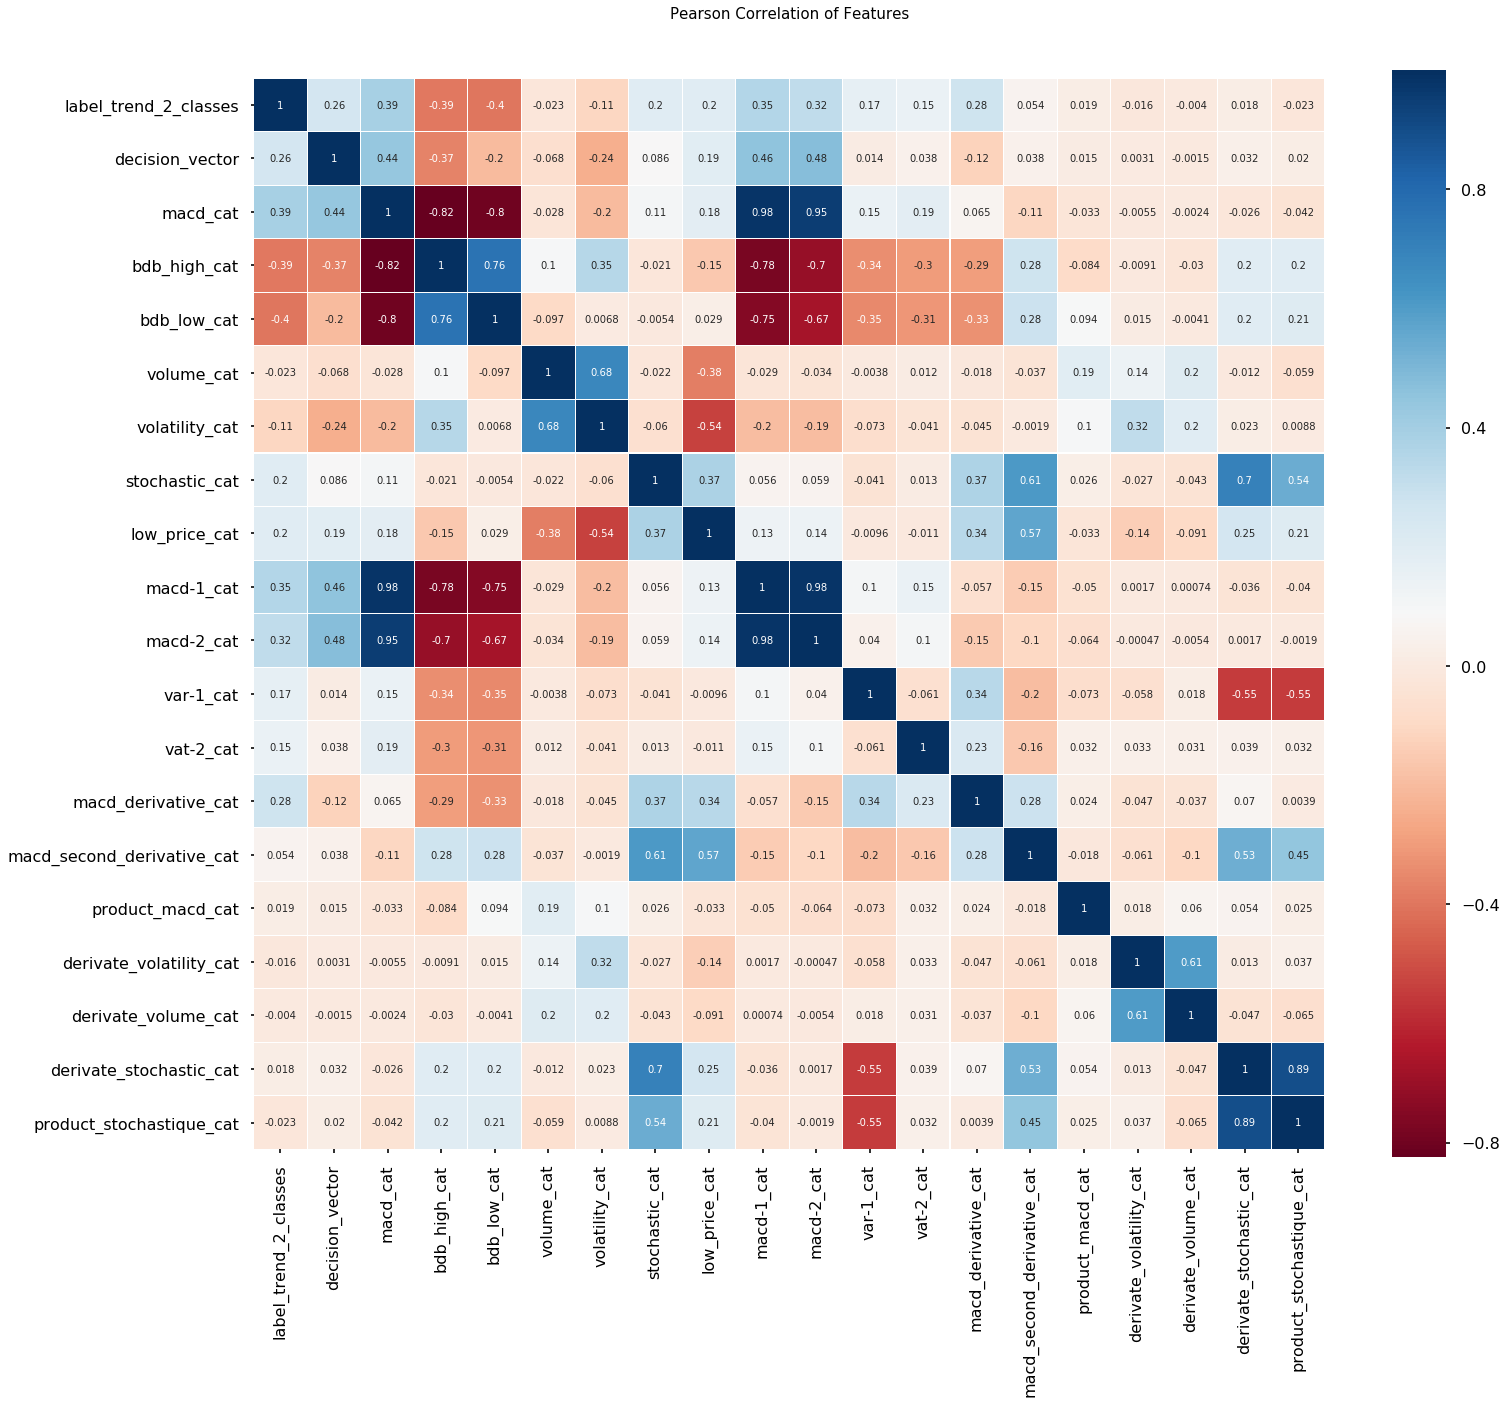

,label_trend_2_classes,decision_vector,macd_cat,bdb_high_cat,bdb_low_cat,volume_cat,volatility_cat,stochastic_cat,low_price_cat,macd-1_cat,macd-2_cat,var-1_cat,vat-2_cat,macd_derivative_cat,macd_second_derivative_cat,product_macd_cat,derivate_volatility_cat,derivate_volume_cat,derivate_stochastic_cat,product_stochastique_cat
3,0.0,0.0,8,7,10,0,4,7,8,8,9,0,2,2,10,2,1,4,11,10
4,0.0,0.0,5,7,7,9,12,3,0,8,8,8,0,0,0,5,12,12,3,2
5,0.0,1.0,5,11,12,8,11,11,12,5,8,0,8,2,12,7,0,2,12,12
6,0.0,1.0,4,9,9,6,10,2,3,5,5,12,0,1,3,9,1,2,0,1
7,0.0,1.0,3,10,10,7,8,9,2,4,5,3,12,2,7,9,3,9,11,11


In [5]:
df_full_cat = df_primary.copy()

df_full_cat['macd_cat'] = pd.qcut(df_primary['macd_n'], 13, labels=False)
df_full_cat['bdb_high_cat'] = pd.qcut(df_primary['bdb_high_n'], 13, labels=False)
df_full_cat['bdb_low_cat'] = pd.qcut(df_primary['bdb_low_n'], 13, labels=False)
df_full_cat['volume_cat'] = pd.qcut(df_primary['volume'], 13, labels=False)
df_full_cat['volatility_cat'] = pd.qcut(df_primary['volatility'], 13, labels=False)
df_full_cat['stochastic_cat'] = pd.qcut(df_primary['stochastic'], 13, labels=False)
df_full_cat['low_price_cat'] = pd.qcut(df_primary['low_price_n'], 13, labels=False)
df_full_cat['macd-1_cat'] = pd.qcut(df_primary['macd-1'], 13, labels=False)
df_full_cat['macd-2_cat'] = pd.qcut(df_primary['macd-2'], 13, labels=False)
df_full_cat['var-1_cat'] = pd.qcut(df_primary['var-1'], 13, labels=False)
df_full_cat['vat-2_cat'] = pd.qcut(df_primary['var-2'], 13, labels=False)
df_full_cat['macd_derivative_cat'] = pd.qcut(df_primary['macd_derivative_n'], 13, labels=False)
df_full_cat['macd_second_derivative_cat'] = pd.qcut(df_primary['macd_second_derivative_n'], 13, labels=False)
df_full_cat['product_macd_cat'] = pd.qcut(df_primary['product_macd'], 13, labels=False)
df_full_cat['derivate_volatility_cat'] = pd.qcut(df_primary['derivate_volatility'], 13, labels=False)
df_full_cat['derivate_volume_cat'] = pd.qcut(df_primary['derivate_volume'], 13, labels=False)
df_full_cat['derivate_stochastic_cat'] = pd.qcut(df_primary['stochastic_derivative'], 13, labels=False)
df_full_cat['product_stochastique_cat'] = pd.qcut(df_primary['product_stochastic'], 13, labels=False)

ciao = ['volume','stochastic','bdb_high_n','bdb_low_n','high_price_n',
 'low_price_n','macd_n','macd-1','macd-2','macd-3','variation','var-1',
 'var-2' ,'macd_derivative_n', 'macd_second_derivative_n' ,'product_macd',
 'volatility' ,'derivate_volatility' ,'derivate_volume',
 'stochastic_derivative' ,'product_stochastic' ,
 'label_basique' ,'label_forte_variation', 'label_trend_3_classes']

df_full_cat = df_full_cat.drop(ciao, axis = 1)

colormap = plt.cm.RdBu
plt.figure(figsize=(24,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_full_cat.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

df_full_cat.head()

Common feature selection techniques
===
Test Chi2 
----
which is like pearson correlation but for discretized data<br>


Principal Component Analysis
----
PCA, which try to prnoject our n dimensional space in a p dimensional (p<n) and in the mean time has to keep the most informations<br>

Non Negative Matrix Function
----
NMF to clarify

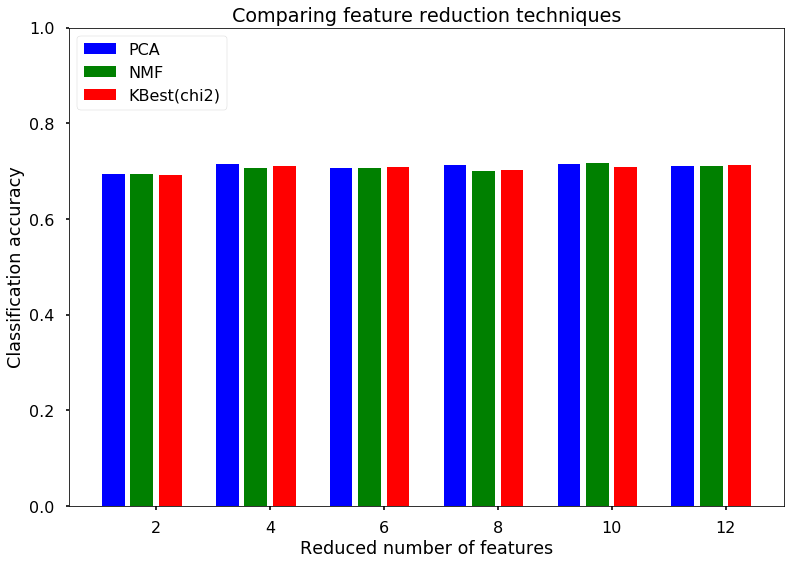

In [6]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2

X_selection = np.array(df_full_cat.drop('label_trend_2_classes', 1))
y_selection = np.array(df_full_cat['label_trend_2_classes'])

pipe = Pipeline([
    ('reduce_dim', PCA()),
    ('classify', LinearSVC())
])

N_FEATURES_OPTIONS = [2, 4, 6, 8, 10, 12]
C_OPTIONS = [1, 10, 100]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'classify__C': C_OPTIONS
    },
]
reducer_labels = ['PCA', 'NMF', 'KBest(chi2)']

grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_selection, y_selection)

mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(len(C_OPTIONS), -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()

According to the graph above, the PCA is the best way to reduce our number of features among the three techniques. We are going to build a dataset with a PCA.

In [7]:
df_primary.columns.values
print(mean_scores)

[[ 0.69363937  0.7152305   0.70764443  0.71231278  0.71581404  0.71017312]
 [ 0.69325034  0.70589379  0.70608831  0.70044738  0.71639759  0.7099786 ]
 [ 0.69130519  0.7099786   0.70842249  0.70258705  0.70900603  0.71347987]]


In [8]:

from sklearn.preprocessing import StandardScaler

data = df_primary.copy()
y_PCA = data['label_trend_2_classes']
salut = ['label_basique', 'label_forte_variation', 'label_trend_3_classes', 'label_trend_2_classes']
data = data.drop(salut, 1)

scaler = StandardScaler()

X_PCA = data

X_PCA = scaler.fit_transform(X_PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=12)
principalComponents = pca.fit_transform(X_PCA)
df_X_PCA = pd.DataFrame(data = principalComponents
             , columns = ['ACP_1','ACP_2','ACP_3','ACP_4','ACP_5','ACP_6','ACP_7','ACP_8','ACP_9','ACP_10', 'ACP_11', 'ACP_12'])
print(sum(pca.explained_variance_ratio_.tolist()))
df_X_PCA.head()

0.973089310341344


,ACP_1,ACP_2,ACP_3,ACP_4,ACP_5,ACP_6,ACP_7,ACP_8,ACP_9,ACP_10,ACP_11,ACP_12
0,-0.293055,-1.392982,-0.517459,-1.963275,-0.052117,0.481585,0.458575,-0.768701,-1.656772,-0.513512,-0.149039,0.110196
1,0.421601,5.480874,3.544722,-0.977766,0.091294,-0.349468,3.148112,-0.497662,-0.981769,1.699145,1.162200,-0.097433
2,2.070637,-4.723739,1.026598,-2.314825,1.238242,1.290887,-1.626263,-1.444769,0.077360,-0.604176,0.205347,0.047612
3,0.032181,1.676892,-1.025525,1.064939,3.298559,0.518566,1.180573,1.646029,0.088853,0.412329,-0.522825,-1.070106
4,0.608780,-0.806131,0.390033,-1.845917,-2.087545,0.460976,-0.255192,-0.566805,1.560840,-0.497982,0.588186,-0.904250


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split  

df_PCA = df_primary.copy()

y = np.array(df_PCA['label_trend_2_classes'])

salut = ['label_basique', 'label_forte_variation', 'label_trend_3_classes', 'label_trend_2_classes']
X = np.array(df_PCA.drop(salut, 1))

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
taille = 0.8
X_train, X_test, y_train, y_test = X[:int(len(X)*taille)], X[int(len(X)*taille):], y[:int(len(X)*taille)], y[int(len(X)*taille):]

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.decomposition import PCA

pca = PCA(n_components = 12)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

print(sum(pca.explained_variance_ratio_.tolist()))


0.9729575086856577


Features selection confirmation
====
1) MACD & derivates
----

In [10]:
df_train = df_primary.copy()

# macd_n relevant ?
df_train['macd_cat'] = pd.qcut(df_train['macd_n'], 13, labels=False)
print(df_train[['macd_cat', 'label_trend_2_classes']].
      groupby(['macd_cat'], as_index=False).
      mean().
      sort_values(by='macd_cat', ascending=True))
# Yes 


# macd_derivative relevant ?
df_train['macd_derivative_cat'] = pd.qcut(df_train['macd_derivative_n'], 13, labels=False)
print(df_train[['macd_derivative_cat', 'label_trend_2_classes']].
      groupby(['macd_derivative_cat'], as_index=False).
      mean().
      sort_values(by='macd_derivative_cat', ascending=True))
# Yes 


# macd_seconde relevant ?
df_train['macd_sec_der_cat'] = pd.qcut(df_train['macd_second_derivative_n'], 10, labels=False)
print(df_train[['macd_sec_der_cat', 'label_trend_2_classes']].
      groupby(['macd_sec_der_cat'], as_index=False).
      mean().
      sort_values(by='macd_sec_der_cat', ascending=True))
# NO...
df_train = df_train.drop('macd_sec_der_cat', axis=1)


    macd_cat  label_trend_2_classes
0          0               0.239899
1          1               0.270886
2          2               0.353535
3          3               0.313924
4          4               0.367089
5          5               0.464646
6          6               0.541772
7          7               0.590909
8          8               0.681013
9          9               0.701266
10        10               0.732323
11        11               0.815190
12        12               0.805556
    macd_derivative_cat  label_trend_2_classes
0                     0               0.239899
1                     1               0.313924
2                     2               0.368687
3                     3               0.450633
4                     4               0.496203
5                     5               0.550505
6                     6               0.546835
7                     7               0.603535
8                     8               0.607595
9                     9   

2) BDB low & high
-----

In [11]:
df_train1 = df_train.copy()

# bdb_low_relevant ? (achat classique a bdb_low proche de 12, zone de survente)
df_train1['bdb_low_cat'] = pd.qcut(df_train1['bdb_low_n'], 13, labels=False)
print(df_train1[['bdb_low_cat', 'label_trend_2_classes']].
      groupby(['bdb_low_cat'], as_index=False).
      mean().
      sort_values(by='bdb_low_cat', ascending=True))
# Yes 


# bdb_high_relevant ? (vente classique a bdb_high proche de 0, zone de surachat)
df_train1['bdb_high_cat'] = pd.qcut(df_train1['bdb_high_n'], 13, labels=False)
print(df_train1[['bdb_high_cat', 'label_trend_2_classes']].
      groupby(['bdb_high_cat'], as_index=False).
      mean().
      sort_values(by='bdb_high_cat', ascending=True))
# Yes

df_train1.head()

    bdb_low_cat  label_trend_2_classes
0             0               0.805556
1             1               0.815190
2             2               0.724747
3             3               0.726582
4             4               0.658228
5             5               0.598485
6             6               0.501266
7             7               0.459596
8             8               0.465823
9             9               0.374684
10           10               0.320707
11           11               0.222785
12           12               0.204545
    bdb_high_cat  label_trend_2_classes
0              0               0.823232
1              1               0.825316
2              2               0.729798
3              3               0.713924
4              4               0.670886
5              5               0.575758
6              6               0.475949
7              7               0.459596
8              8               0.359494
9              9               0.364557
10            

,volume,stochastic,bdb_high_n,bdb_low_n,high_price_n,low_price_n,macd_n,macd-1,macd-2,macd-3,...,product_stochastic,label_basique,label_forte_variation,label_trend_3_classes,label_trend_2_classes,decision_vector,macd_cat,macd_derivative_cat,bdb_low_cat,bdb_high_cat
3,14.755165,0.642795,1.016936,0.999783,1.006496,0.998110,0.004800,0.006018,0.007894,0.008307,...,0.413185,1,0,0.0,0.0,0.0,8,2,10,7
4,185.642850,0.261647,1.016472,0.989490,1.000002,0.940442,0.000169,0.004800,0.006018,0.007894,...,-0.099726,-1,1,-1.0,0.0,0.0,5,0,7,7
5,141.111493,0.999927,1.063922,1.035350,1.035192,1.000000,-0.000882,0.000169,0.004800,0.006018,...,0.738227,1,1,0.0,0.0,1.0,5,2,12,11
6,100.007762,0.160596,1.027695,0.998875,1.013428,0.990375,-0.002384,-0.000882,0.000169,0.004800,...,-0.134793,-1,0,-1.0,0.0,1.0,4,1,9,9
7,129.721791,0.853758,1.033495,1.003121,1.001240,0.982892,-0.003720,-0.002384,-0.000882,0.000169,...,0.591792,0,0,-1.0,0.0,1.0,3,2,10,10


3) Stochastic
----

In [12]:
df_train2 = df_train1.copy()
df_train2['stochastic_cat'] = pd.qcut(df_train2['stochastic'], 13, labels=False)
print(df_train2[['stochastic_cat', 'label_trend_2_classes']].
      groupby(['stochastic_cat'], as_index=False).
      mean().
      sort_values(by='stochastic_cat', ascending=True))

    stochastic_cat  label_trend_2_classes
0                0               0.398990
1                1               0.346835
2                2               0.419192
3                3               0.455696
4                4               0.475949
5                5               0.505051
6                6               0.549367
7                7               0.535354
8                8               0.620253
9                9               0.625316
10              10               0.598485
11              11               0.663291
12              12               0.684343


Volume / Volatility
----

In [13]:
df_train3 = df_train2.copy()
df_train3['volume_cat'] = pd.qcut(df_train3['volume'], 20, labels=False)
print(df_train3[['volume_cat', 'label_trend_2_classes']].
      groupby(['volume_cat'], as_index=False).
      mean().
      sort_values(by='volume_cat', ascending=True))

df_train3['volatility_cat'] = pd.qcut(df_train3['volatility'], 20, labels=False)
print(df_train3[['volatility_cat', 'label_trend_2_classes']].
      groupby(['volatility_cat'], as_index=False).
      mean().
      sort_values(by='volatility_cat', ascending=True))
# drop volume / volatilite cause not relevant (P.S. we see an important correlation if we take the high_variation_label)


    volume_cat  label_trend_2_classes
0            0               0.523256
1            1               0.568093
2            2               0.556420
3            3               0.517510
4            4               0.552529
5            5               0.571984
6            6               0.525292
7            7               0.552529
8            8               0.501946
9            9               0.509728
10          10               0.564202
11          11               0.552529
12          12               0.494163
13          13               0.529183
14          14               0.474708
15          15               0.482490
16          16               0.509728
17          17               0.587549
18          18               0.490272
19          19               0.517510
    volatility_cat  label_trend_2_classes
0                0               0.647287
1                1               0.634241
2                2               0.603113
3                3               0

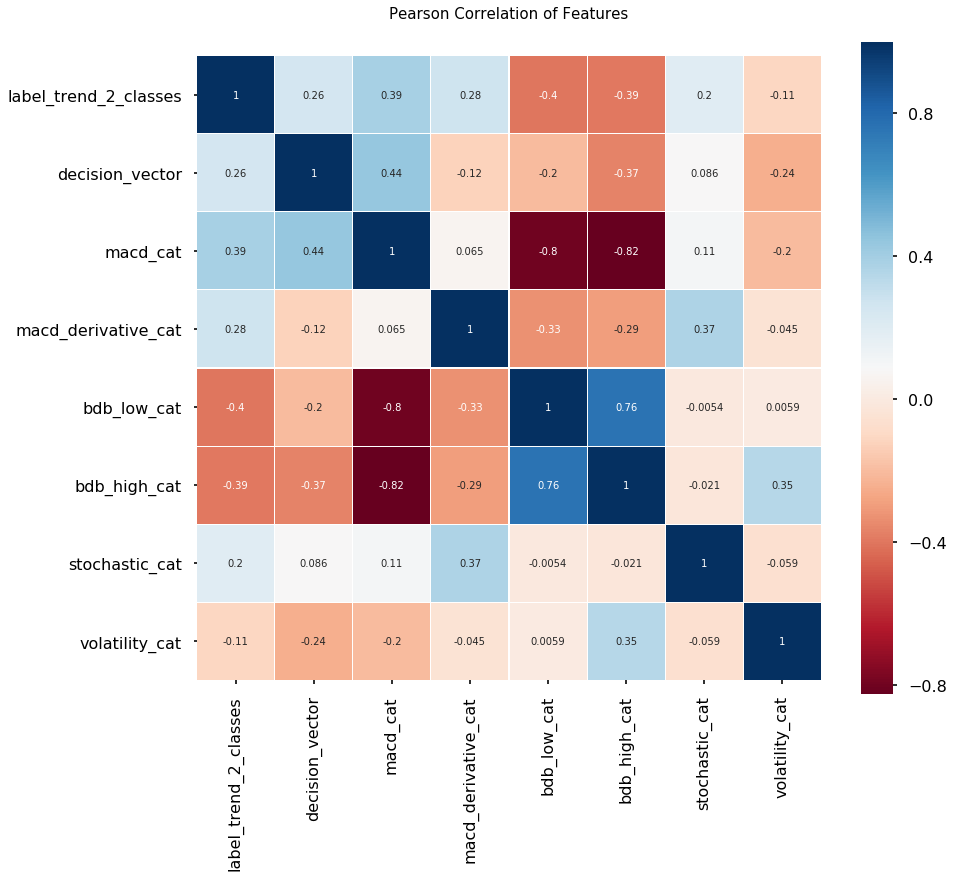

In [14]:
# Pearson Correlation of features with our new features selected (no add value, but to see easier)
df_train4 = df_train3.copy()
drop = ['volume', 'stochastic', 'bdb_high_n', 'bdb_low_n', 'high_price_n',
       'low_price_n', 'macd_n', 'macd-1', 'macd-2', 'macd-3',
       'var-1', 'var-2', 'macd_derivative_n', 'macd_second_derivative_n',
       'product_macd', 'volatility', 'derivate_volatility', 'derivate_volume',
       'stochastic_derivative', 'product_stochastic',
       'label_basique', 'label_forte_variation', 'label_trend_3_classes', 'volume_cat','variation']
df_train4 = df_train3.drop(drop, axis = 1)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_train4.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()


Création des dataset de test et d'entrainement
----
Nous pourrons changer à notre aise le dataframe que nous voulons tester

In [15]:
#df = df_train4.copy()
#df = df_full_cat.copy()

from sklearn.model_selection import train_test_split       


#X = np.array(df.drop('label_trend_2_classes', 1))
#y = np.array(df['label_trend_2_classes'])
X = np.array(df_X_PCA)
y = np.array(y_PCA)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):], y[:int(len(X)*0.8)], y[int(len(X)*0.8):]

Testing
====
Ici, nous allons tester 20 modèles différents pour tester chacun de nos dataframe et voir lequel permet d'obtenir les meilleurs scores


In [16]:
#Machine Learning Algorithm (MLA) Selection and Initialization
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators = 500),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators = 500),
    ensemble.GradientBoostingClassifier(n_estimators = 500),
    ensemble.RandomForestClassifier(n_estimators = 500),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(tol=1e-3, max_iter=1000),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(tol=1e-3, max_iter=1000),
    linear_model.Perceptron(tol=1e-3, max_iter=1000),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),   
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#index through MLA and save performance to table
row_index = 0
features_importances = []

for alg in MLA:
    print('Il reste ' + str(len(MLA) - row_index) +' algorithmes à exécuter.')
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Il reste 21 algorithmes à exécuter.
Il reste 20 algorithmes à exécuter.
Il reste 19 algorithmes à exécuter.
Il reste 18 algorithmes à exécuter.
Il reste 17 algorithmes à exécuter.
Il reste 16 algorithmes à exécuter.
Il reste 15 algorithmes à exécuter.
Il reste 14 algorithmes à exécuter.
Il reste 13 algorithmes à exécuter.
Il reste 12 algorithmes à exécuter.
Il reste 11 algorithmes à exécuter.
Il reste 10 algorithmes à exécuter.
Il reste 9 algorithmes à exécuter.
Il reste 8 algorithmes à exécuter.
Il reste 7 algorithmes à exécuter.
Il reste 6 algorithmes à exécuter.
Il reste 5 algorithmes à exécuter.
Il reste 4 algorithmes à exécuter.
Il reste 3 algorithmes à exécuter.
Il reste 2 algorithmes à exécuter.
Il reste 1 algorithmes à exécuter.


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.727442,0.718801,0.0184188,0.0996148
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",1,0.714992,0.0206302,3.09451
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.769396,0.712885,0.0229622,0.912574
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.721889,0.712237,0.0205268,0.246864
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",1,0.709643,0.0193591,1.7106
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.715971,0.707293,0.0158601,0.00156219
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.715728,0.707212,0.0159066,0.00348756
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.865464,0.699919,0.0192366,5.07372
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.958492,0.693274,0.0302525,1.50798
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.825051,0.692464,0.02487,1.35194


In [17]:
# Some useful parameters which will come in handy later on
from sklearn.cross_validation import KFold
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)
#rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, params=None):
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

C:\Users\flore\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : 19
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : 19
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state' : 19
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : 19
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025,
    'random_state' : 19
    }

new_params = {
    'tol' : 1e-3,
    'max_iter' : 1000
}

random_state = {
    'random_state' : 19
}

In [19]:
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics


# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, params=gb_params)
svc = SklearnHelper(clf=SVC, params=svc_params)
bag = SklearnHelper(clf=ensemble.BaggingClassifier, params=random_state)
gauss = SklearnHelper(clf=gaussian_process.GaussianProcessClassifier, params=random_state)
log = SklearnHelper(clf=linear_model.LogisticRegressionCV, params=random_state)
pasag = SklearnHelper(clf=linear_model.PassiveAggressiveClassifier, params=new_params)
ridge = SklearnHelper(clf=linear_model.RidgeClassifierCV, params={})
SGDC = SklearnHelper(clf=linear_model.SGDClassifier, params=new_params)
perc = SklearnHelper(clf=linear_model.Perceptron, params=new_params)
naiveb = SklearnHelper(clf=naive_bayes.BernoulliNB, params={})
naiveg = SklearnHelper(clf=naive_bayes.GaussianNB, params={})
knn = SklearnHelper(clf=neighbors.KNeighborsClassifier, params={})             
svmm = SklearnHelper(clf=svm.LinearSVC, params=random_state)  
lda = SklearnHelper(clf=discriminant_analysis.LinearDiscriminantAnalysis, params={})                 
qda = SklearnHelper(clf=discriminant_analysis.QuadraticDiscriminantAnalysis, params={})                 
nusvc = SklearnHelper(clf=svm.NuSVC, params=random_state)

In [20]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,X_train, y_train, X_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,X_train, y_train, X_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,X_train, y_train, X_test) # Support Vector Classifier
bag_oof_train, bag_oof_test = get_oof(bag,X_train, y_train, X_test)
gauss_oof_train, gauss_oof_test = get_oof(gauss,X_train, y_train, X_test)
log_oof_train, log_oof_test = get_oof(log,X_train, y_train, X_test)
pasag_oof_train, pasag_oof_test = get_oof(pasag,X_train, y_train, X_test)
ridge_oof_train, ridge_oof_test = get_oof(ridge,X_train, y_train, X_test)
SGDC_oof_train, SGDC_oof_test = get_oof(SGDC,X_train, y_train, X_test)
perc_oof_train, perc_oof_test = get_oof(perc,X_train, y_train, X_test)
naiveb_oof_train, naiveb_oof_test = get_oof(naiveb,X_train, y_train, X_test)
naiveg_oof_train, naiveg_oof_test = get_oof(naiveg,X_train, y_train, X_test)
knn_oof_train, knn_oof_test = get_oof(knn,X_train, y_train, X_test)
nusvc_oof_train, nusvc_oof_test = get_oof(nusvc,X_train, y_train, X_test)
svmm_oof_train, svmm_oof_test = get_oof(svmm,X_train, y_train, X_test)
lda_oof_train, lda_oof_test = get_oof(lda,X_train, y_train, X_test)
qda_oof_train, qda_oof_test = get_oof(qda,X_train, y_train, X_test)

C:\Users\flore\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


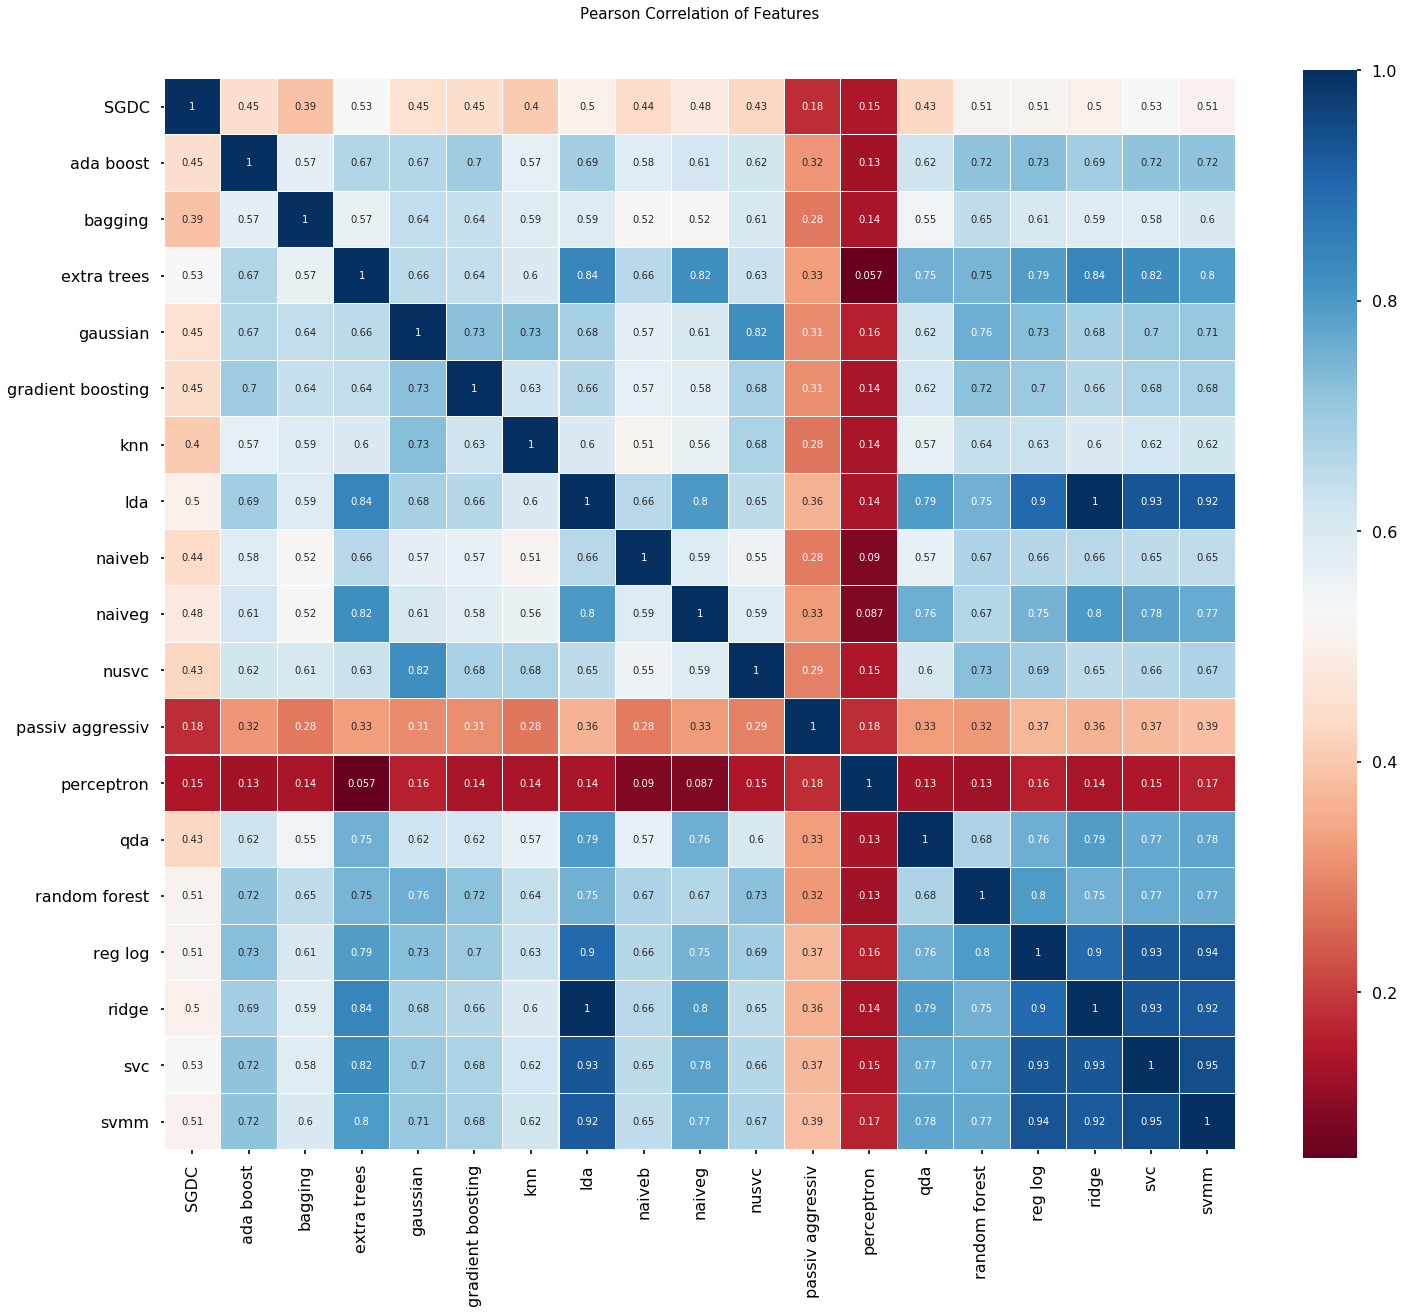

In [22]:
X_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train,
                         bag_oof_train, gauss_oof_train, log_oof_train, pasag_oof_train, ridge_oof_train,
                         SGDC_oof_train, perc_oof_train, naiveb_oof_train, naiveg_oof_train,
                         knn_oof_train, nusvc_oof_train, svmm_oof_train, lda_oof_train, qda_oof_train), axis=1)
pred_train_df = pd.DataFrame({'extra trees': et_oof_train.ravel(),
                              'random forest': rf_oof_train.ravel(),
                              'ada boost': ada_oof_train.ravel(),
                              'gradient boosting': gb_oof_train.ravel(),
                              'svc': svc_oof_train.ravel(),
                              'bagging': bag_oof_train.ravel(),
                              'gaussian': gauss_oof_train.ravel(),
                              'reg log': log_oof_train.ravel(),
                              'passiv aggressiv': pasag_oof_train.ravel(),
                              'ridge': ridge_oof_train.ravel(),
                              'SGDC': SGDC_oof_train.ravel(),
                              'perceptron': perc_oof_train.ravel(),
                              'naiveb': naiveb_oof_train.ravel(),
                              'naiveg': naiveg_oof_train.ravel(),
                              'knn': knn_oof_train.ravel(),
                              'nusvc': nusvc_oof_train.ravel(),
                              'svmm': svmm_oof_train.ravel(),
                              'lda': lda_oof_train.ravel(),
                              'qda': qda_oof_train.ravel(),
                             })
colormap = plt.cm.RdBu
plt.figure(figsize=(24,20))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(pred_train_df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()
X_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test,
                         bag_oof_test, gauss_oof_test, log_oof_test, pasag_oof_test, ridge_oof_test,
                         SGDC_oof_test, perc_oof_test, naiveb_oof_test, naiveg_oof_test,
                         knn_oof_test, nusvc_oof_test, svmm_oof_test, lda_oof_test, qda_oof_test), axis=1)


In [23]:
X_train = np.concatenate((rf_oof_train, ada_oof_train, gb_oof_train,
                         bag_oof_train, gauss_oof_train, log_oof_train, pasag_oof_train,
                         SGDC_oof_train, perc_oof_train, naiveg_oof_train,
                         knn_oof_train, lda_oof_train, ), axis=1)

X_test = np.concatenate((rf_oof_test, ada_oof_test, gb_oof_test,
                         bag_oof_test, gauss_oof_test, log_oof_test, pasag_oof_test,
                         SGDC_oof_test, perc_oof_test, naiveg_oof_test,
                         knn_oof_test, lda_oof_test), axis=1)


In [25]:
#Machine Learning Algorithm (MLA) Selection and Initialization
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process


#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators = 500),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(n_estimators = 500),
    ensemble.GradientBoostingClassifier(n_estimators = 500),
    ensemble.RandomForestClassifier(n_estimators = 500),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(tol=1e-3, max_iter=1000),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(tol=1e-3, max_iter=1000),
    linear_model.Perceptron(tol=1e-3, max_iter=1000),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),   
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)


#index through MLA and save performance to table
row_index = 0
features_importances = []
for alg in MLA:
    print('Il reste ' + str(len(MLA) - row_index) +' algorithmes à exécuter.')
    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv  = cv_split, return_train_score=True)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

Il reste 21 algorithmes à exécuter.
Il reste 20 algorithmes à exécuter.
Il reste 19 algorithmes à exécuter.
Il reste 18 algorithmes à exécuter.
Il reste 17 algorithmes à exécuter.
Il reste 16 algorithmes à exécuter.
Il reste 15 algorithmes à exécuter.
Il reste 14 algorithmes à exécuter.
Il reste 13 algorithmes à exécuter.
Il reste 12 algorithmes à exécuter.
Il reste 11 algorithmes à exécuter.
Il reste 10 algorithmes à exécuter.
Il reste 9 algorithmes à exécuter.
Il reste 8 algorithmes à exécuter.
Il reste 7 algorithmes à exécuter.
Il reste 6 algorithmes à exécuter.
Il reste 5 algorithmes à exécuter.
Il reste 4 algorithmes à exécuter.
Il reste 3 algorithmes à exécuter.
Il reste 2 algorithmes à exécuter.
Il reste 1 algorithmes à exécuter.


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.771869,0.772609,0.0108832,0.987052
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.771909,0.772609,0.0108832,0.963146
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.771909,0.772609,0.0108832,0.00375223
16,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.771909,0.772609,0.0108832,0.0575637
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.771909,0.772609,0.0108832,0.0810764
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.771909,0.772609,0.0108832,1.21139
8,RidgeClassifierCV,"{'alphas': (0.1, 1.0, 10.0), 'class_weight': N...",0.771909,0.772609,0.0108832,0.00411792
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.777706,0.768801,0.0151062,5.16584
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.76591,0.767666,0.0290526,0.00468645
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.784516,0.755592,0.0187433,0.881232


- 6 variables catégorisées sans Stacking 72%
- 6 variables catégorisées avec Stacking 75.5%
- 6 variables non catégorisées sans Stacking 72.2%
- 6 variables non catégorisées avec Stacking 77%
- Toutes les variables catégorisées sans Stacking 71.9%
- Toutes les variables catégorisées avec Stacking 76.2%
- 10 variables catégorisées sans Stacking 71.9%
- 10 variables catégorisées avec Stacking 75.8%
- PCA 12 composantes non catégorisées sans Stacking 75.7%
- PCA 12 composantes non catégorisées avec Stacking 80.7%